# Train SVM models

## Read data

In [1]:
import os
import re
import pandas as pd
import numpy as np
import random
import sklearn
import codecs
import collections
from tqdm import tqdm

from sklearn.metrics import classification_report, accuracy_score

random.seed(42)
np.random.seed(42)

In [2]:
TRAIN_DIR = "./data/training/"
TRAIN_SUFFIX = "-train.txt"

DEV_DIR = "./data/development/"
DEV_SUFFIX = "-dev.txt"

TEST_DIR = "./data/test-gold/"
TEST_SUFFIX = "-test-gold.txt"

YEAR_PREFIX = "2018-"
FILE_PREFIX = "EI-oc-En-"

EMOTIONS = ["anger", "fear", "joy", "sadness"] 
LABEL_EMOTIONS = {i: emo for i, emo in enumerate(EMOTIONS)}
EMOTIONS_LABEL = {emo: i for i, emo in enumerate(EMOTIONS)}

In [3]:
TRAIN_FILES = []
DEV_FILES = []
TEST_FILES = []

for emo in EMOTIONS: 
    TRAIN_FILES += [TRAIN_DIR + FILE_PREFIX + emo + TRAIN_SUFFIX]
    DEV_FILES += [DEV_DIR + YEAR_PREFIX + FILE_PREFIX + emo + DEV_SUFFIX]
    TEST_FILES += [TEST_DIR + YEAR_PREFIX + FILE_PREFIX + emo + TEST_SUFFIX]

for file in TRAIN_FILES + DEV_FILES + TEST_FILES:
    print(file, os.path.exists(file))

./data/training/EI-oc-En-anger-train.txt True
./data/training/EI-oc-En-fear-train.txt True
./data/training/EI-oc-En-joy-train.txt True
./data/training/EI-oc-En-sadness-train.txt True
./data/development/2018-EI-oc-En-anger-dev.txt True
./data/development/2018-EI-oc-En-fear-dev.txt True
./data/development/2018-EI-oc-En-joy-dev.txt True
./data/development/2018-EI-oc-En-sadness-dev.txt True
./data/test-gold/2018-EI-oc-En-anger-test-gold.txt True
./data/test-gold/2018-EI-oc-En-fear-test-gold.txt True
./data/test-gold/2018-EI-oc-En-joy-test-gold.txt True
./data/test-gold/2018-EI-oc-En-sadness-test-gold.txt True


In [4]:
TRAIN_DATA = pd.concat(pd.read_csv(f, sep='\t') for f in TRAIN_FILES)
TRAIN_DATA = sklearn.utils.shuffle(TRAIN_DATA)
TRAIN_DATA        

,ID,Tweet,Affect Dimension,Intensity Class
526,2017-En-41199,Incredibly shocked and disappointed with @unit...,sadness,3: high amount of sadness can be inferred
494,2017-En-30873,If yiu don't respond .o an email within 7 days...,joy,0: no joy can be inferred
724,2017-En-30332,Watch this amazing live.ly broadcast by @maisi...,joy,2: moderate amount of joy can be inferred
879,2017-En-31279,But I got to see her last when she was lively ...,joy,0: no joy can be inferred
2095,2017-En-21925,@ThomasHCrown @laurakfillault As a historic ev...,fear,0: no fear can be inferred
...,...,...,...,...
2071,2017-En-22224,today afghanistan tell us where the terrorism ...,fear,2: moderate amount of fear can be inferred
1238,2017-En-31048,#IfIWerePresident \nMy goal would be for us al...,joy,0: no joy can be inferred
1273,2017-En-31241,@1barkcom Thank you for the #follow. Looking f...,joy,2: moderate amount of joy can be inferred
1437,2017-En-31232,"The best part of this day, Jesus, is to snuggl...",joy,3: high amount of joy can be inferred


In [5]:
TRAIN_DATA["Category"] = TRAIN_DATA["Affect Dimension"]
TRAIN_DATA["Label"] = TRAIN_DATA["Affect Dimension"].apply(lambda x: EMOTIONS_LABEL[x])
TRAIN_DATA["Intensity"] = TRAIN_DATA["Intensity Class"].apply(lambda x: int(x[0]))
TRAIN_DATA

,ID,Tweet,Affect Dimension,Intensity Class,Category,Label,Intensity
526,2017-En-41199,Incredibly shocked and disappointed with @unit...,sadness,3: high amount of sadness can be inferred,sadness,3,3
494,2017-En-30873,If yiu don't respond .o an email within 7 days...,joy,0: no joy can be inferred,joy,2,0
724,2017-En-30332,Watch this amazing live.ly broadcast by @maisi...,joy,2: moderate amount of joy can be inferred,joy,2,2
879,2017-En-31279,But I got to see her last when she was lively ...,joy,0: no joy can be inferred,joy,2,0
2095,2017-En-21925,@ThomasHCrown @laurakfillault As a historic ev...,fear,0: no fear can be inferred,fear,1,0
...,...,...,...,...,...,...,...
2071,2017-En-22224,today afghanistan tell us where the terrorism ...,fear,2: moderate amount of fear can be inferred,fear,1,2
1238,2017-En-31048,#IfIWerePresident \nMy goal would be for us al...,joy,0: no joy can be inferred,joy,2,0
1273,2017-En-31241,@1barkcom Thank you for the #follow. Looking f...,joy,2: moderate amount of joy can be inferred,joy,2,2
1437,2017-En-31232,"The best part of this day, Jesus, is to snuggl...",joy,3: high amount of joy can be inferred,joy,2,3


In [6]:
TRAIN_DATA["Category"].value_counts()

fear       2252
anger      1701
joy        1616
sadness    1533
Name: Category, dtype: int64

In [7]:
TRAIN_CATEGORY_WEIGHTS = TRAIN_DATA["Category"].value_counts().to_dict()
TRAIN_LABEL_WEIGHTS =  TRAIN_DATA["Label"].value_counts().to_dict()

In [8]:
DEV_DATA = pd.concat(pd.read_csv(f, sep='\t') for f in DEV_FILES)
DEV_DATA = sklearn.utils.shuffle(DEV_DATA)
DEV_DATA

,ID,Tweet,Affect Dimension,Intensity Class
321,2018-En-01824,God this match is dull #Wimbledon,anger,1: low amount of anger can be inferred
62,2018-En-03227,Not only has my flight been delayed numerous t...,fear,1: low amount of fear can be inferred
327,2018-En-00695,@austin_j_powers @I_am_bumface @R9Rai @Holborn...,fear,1: low amount of fear can be inferred
166,2018-En-03038,James Clapper 'scary and disturbing'. #25thAm...,fear,2: moderate amount of fear can be inferred
369,2018-En-03488,I wish EVERYONE could see how #MSNBC #CNN talk...,anger,1: low amount of anger can be inferred
...,...,...,...,...
55,2018-En-00823,Only halfway through #madeforlove by @AlissaNu...,joy,3: high amount of joy can be inferred
266,2018-En-01671,Nigga write me talking bout I dreamt about you...,sadness,0: no sadness can be inferred
207,2018-En-00657,Damn I'm tired as hell I never get a off day d...,sadness,2: moderate amount of sadness can be inferred
235,2018-En-03719,"The blackest abyss of despair, Alonzo",sadness,2: moderate amount of sadness can be inferred


In [9]:
DEV_DATA["Category"] = DEV_DATA["Affect Dimension"]
DEV_DATA["Label"] = DEV_DATA["Affect Dimension"].apply(lambda x: EMOTIONS_LABEL[x])
DEV_DATA["Intensity"] = DEV_DATA["Intensity Class"].apply(lambda x: int(x[0]))
DEV_DATA

,ID,Tweet,Affect Dimension,Intensity Class,Category,Label,Intensity
321,2018-En-01824,God this match is dull #Wimbledon,anger,1: low amount of anger can be inferred,anger,0,1
62,2018-En-03227,Not only has my flight been delayed numerous t...,fear,1: low amount of fear can be inferred,fear,1,1
327,2018-En-00695,@austin_j_powers @I_am_bumface @R9Rai @Holborn...,fear,1: low amount of fear can be inferred,fear,1,1
166,2018-En-03038,James Clapper 'scary and disturbing'. #25thAm...,fear,2: moderate amount of fear can be inferred,fear,1,2
369,2018-En-03488,I wish EVERYONE could see how #MSNBC #CNN talk...,anger,1: low amount of anger can be inferred,anger,0,1
...,...,...,...,...,...,...,...
55,2018-En-00823,Only halfway through #madeforlove by @AlissaNu...,joy,3: high amount of joy can be inferred,joy,2,3
266,2018-En-01671,Nigga write me talking bout I dreamt about you...,sadness,0: no sadness can be inferred,sadness,3,0
207,2018-En-00657,Damn I'm tired as hell I never get a off day d...,sadness,2: moderate amount of sadness can be inferred,sadness,3,2
235,2018-En-03719,"The blackest abyss of despair, Alonzo",sadness,2: moderate amount of sadness can be inferred,sadness,3,2


## Tweet cleaning

In [10]:
#For Pre-Processing
import emoji
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize

import nltk
nltk.download('wordnet')

stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# For visualizing
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to /home/cwh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
def decode_emoji(text):
    output = []
    for t in emoji.demojize(text).split():
        output.extend(t.split("_"))
    return ' '.join(output)

def decode_HTML(text):
    return BeautifulSoup(text, 'lxml').get_text()

def remove_mention(text):
    return re.sub(r'@[A-Za-z0-9]+', '', text)
    
def remove_URL(text):
    return re.sub(r"http\S+", "", text)

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', ' ', text)

def correct_repeatted_letters(text):
    return re.sub(r'(.)\1+', r'\1\1', text)

def to_lowercase(text):
    return ' '.join([w.lower() for w in text.split()])
 
def lemmatize_stemming(text):
    return ' '.join([stemmer.stem(lemmatizer.lemmatize(w, pos='v'))
                     for w in text.split()])

def remove_stop_words(text):
    return ' '.join([w for w in text.split() if w not in stop_words])

In [41]:
def pre_process(text):
    text = decode_emoji(text)
    text = decode_HTML(text)
    text = remove_mention(text)
    text = remove_URL(text)
    text = remove_punctuation(text)
    text = correct_repeatted_letters(text)
    text = to_lowercase(text)       
    text = lemmatize_stemming(text)
    text = remove_stop_words(text)
    return text

In [42]:
for t in TRAIN_DATA["Tweet"][:5]:
    print("BEFORE:", t)
    print("AFTER :", pre_process(t))
    print()

BEFORE: Incredibly shocked and disappointed with @united customer service. Really making me rethink flying with them in the future. #unhappy
AFTER : incred shock disappoint custom servic realli make rethink fli futur unhappi

BEFORE: If yiu don't respond .o an email within 7 days, you willxbe killed by an animated gif of the girl froa The Ri.g.
AFTER : yiu respond email within 7 day willxb kill anim gif girl froa ri g

BEFORE: Watch this amazing live.ly broadcast by @maisiev #lively #musically
AFTER : watch amaz live ly broadcast live music

BEFORE: But I got to see her last when she was lively and talkative and I was able to tell her I loved her so that's what matters.
AFTER : get see last live talkat abl tell love matter

BEFORE: @ThomasHCrown @laurakfillault As a historic evangelical, I wonder if the Donatists had a point? What dreadful clergy in my fmr. circles.
AFTER : histor evangel wonder donatist point dread clergi fmr circl



In [43]:
# Train data cleaning
TRAIN_DATA["Text"] = TRAIN_DATA["Tweet"].apply(lambda s: pre_process(s))
TRAIN_DATA["Text_len"] = TRAIN_DATA["Text"].apply(lambda s: len(s.split()))
TRAIN_DATA.head(5)

,ID,Tweet,Affect Dimension,Intensity Class,Category,Label,Intensity,Text,Text_len
526,2017-En-41199,Incredibly shocked and disappointed with @unit...,sadness,3: high amount of sadness can be inferred,sadness,3,3,incred shock disappoint custom servic realli m...,11
494,2017-En-30873,If yiu don't respond .o an email within 7 days...,joy,0: no joy can be inferred,joy,2,0,yiu respond email within 7 day willxb kill ani...,14
724,2017-En-30332,Watch this amazing live.ly broadcast by @maisi...,joy,2: moderate amount of joy can be inferred,joy,2,2,watch amaz live ly broadcast live music,7
879,2017-En-31279,But I got to see her last when she was lively ...,joy,0: no joy can be inferred,joy,2,0,get see last live talkat abl tell love matter,9
2095,2017-En-21925,@ThomasHCrown @laurakfillault As a historic ev...,fear,0: no fear can be inferred,fear,1,0,histor evangel wonder donatist point dread cle...,9


In [44]:
# Dev data cleaning
DEV_DATA["Text"] = DEV_DATA["Tweet"].apply(lambda s: pre_process(s))
DEV_DATA["Text_len"] = DEV_DATA["Text"].apply(lambda s: len(s.split()))
DEV_DATA.head(5)

,ID,Tweet,Affect Dimension,Intensity Class,Category,Label,Intensity,Text,Text_len
321,2018-En-01824,God this match is dull #Wimbledon,anger,1: low amount of anger can be inferred,anger,0,1,god match dull wimbledon,4
62,2018-En-03227,Not only has my flight been delayed numerous t...,fear,1: low amount of fear can be inferred,fear,1,1,flight delay numer time provid snack cart horrif,8
327,2018-En-00695,@austin_j_powers @I_am_bumface @R9Rai @Holborn...,fear,1: low amount of fear can be inferred,fear,1,1,j power bumfac absolut shock behavour,6
166,2018-En-03038,James Clapper 'scary and disturbing'. #25thAm...,fear,2: moderate amount of fear can be inferred,fear,1,2,jam clapper scari disturb 25thamendmentnow imp...,9
369,2018-En-03488,I wish EVERYONE could see how #MSNBC #CNN talk...,anger,1: low amount of anger can be inferred,anger,0,1,wish everyon could see msnbc cnn talk trump sp...,13


count    7102.000000
mean        9.406646
std         4.368397
min         1.000000
25%         6.000000
50%         9.000000
75%        12.000000
max        79.000000
Name: Text_len, dtype: float64


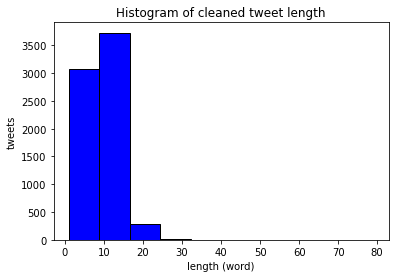

In [45]:
print(TRAIN_DATA["Text_len"].describe())

plt.hist(TRAIN_DATA["Text_len"], color='blue', edgecolor='black')
plt.title('Histogram of cleaned tweet length')
plt.xlabel('length (word)')
plt.ylabel('tweets')
plt.show()

In [46]:
for i, t in TRAIN_DATA.iterrows():
    if t["Text_len"] > 30:
        print("LENGTH", t["Text_len"])
        print("BEFORE:", t["Tweet"])
        print("AFTER :", t["Text"])
        print()

LENGTH 47
BEFORE: i will never watch greys anatomy ever ever ever ever ever again if Shonda Rimes takes away another OG character☹️☹️☹️☹️☹️☹️☹️☹️☹️☹️ #fuming
AFTER : never watch grey anatomi ever ever ever ever ever shonda rim take away anoth og charact frown face selector frown face selector frown face selector frown face selector frown face selector frown face selector frown face selector frown face selector frown face selector frown face selector fume

LENGTH 32
BEFORE: Good morning, Trondheim! #optimism #productivity ⛅️❤️🇳🇴🏢💻🖥🏋🏻💪🏼📺🍿
AFTER : good morn trondheim optim product sun behind cloud red heart selector norway offic build laptop comput desktop comput person lift weight light skin tone flex bicep medium light skin tone televis popcorn

LENGTH 46
BEFORE: i will never watch greys anatomy ever ever ever ever ever again if Shonda Rimes takes away another OG character☹️☹️☹️☹️☹️☹️☹️☹️☹️☹️ 
AFTER : never watch grey anatomi ever ever ever ever ever shonda rim take away anoth og charac

## Random

In [47]:
y_dev = DEV_DATA["Category"]
y_pred = random.choices(EMOTIONS, weights= TRAIN_LABEL_WEIGHTS, k=DEV_DATA.shape[0])

print(classification_report(y_dev, y_pred, target_names=EMOTIONS))
print(accuracy_score(y_dev, y_pred))

              precision    recall  f1-score   support

       anger       0.26      0.16      0.20       388
        fear       0.00      0.00      0.00       389
         joy       0.18      0.30      0.23       290
     sadness       0.27      0.51      0.35       397

    accuracy                           0.24      1464
   macro avg       0.18      0.24      0.20      1464
weighted avg       0.18      0.24      0.19      1464

0.24112021857923496


/home/cwh/anaconda2/envs/p36workshop/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## SVM with raw unigram

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

In [93]:
vectorizer = CountVectorizer(stop_words='english', analyzer='word', ngram_range=(1, 1))

X_train = vectorizer.fit_transform(TRAIN_DATA["Tweet"])
y_train = TRAIN_DATA["Label"]

X_dev = vectorizer.transform(DEV_DATA["Tweet"])
y_dev = DEV_DATA["Label"]

clf = make_pipeline(StandardScaler(with_mean=False), SVC(gamma='auto', class_weight=TRAIN_LABEL_WEIGHTS))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('svc',
                 SVC(class_weight={0: 1701, 1: 2252, 2: 1616, 3: 1533},
                     gamma='auto'))])

In [94]:
y_pred = clf.predict(X_dev)
print(classification_report(y_dev, y_pred, target_names=EMOTIONS))
print(accuracy_score(y_dev, y_pred))

              precision    recall  f1-score   support

       anger       0.40      0.30      0.34       388
        fear       0.31      0.62      0.41       389
         joy       0.53      0.33      0.41       290
     sadness       0.41      0.23      0.30       397

    accuracy                           0.37      1464
   macro avg       0.41      0.37      0.37      1464
weighted avg       0.41      0.37      0.36      1464

0.37158469945355194


## SVM with cleaned unigram

In [96]:
vectorizer = CountVectorizer(stop_words='english', analyzer='word', ngram_range=(1, 1))

X_train = vectorizer.fit_transform(TRAIN_DATA["Text"])
y_train = TRAIN_DATA["Label"]

X_dev = vectorizer.transform(DEV_DATA["Text"])
y_dev = DEV_DATA["Label"]

clf = make_pipeline(StandardScaler(with_mean=False), SVC(gamma='auto', class_weight=TRAIN_LABEL_WEIGHTS))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('svc',
                 SVC(class_weight={0: 1701, 1: 2252, 2: 1616, 3: 1533},
                     gamma='auto'))])

In [97]:
y_pred = clf.predict(X_dev)
print(classification_report(y_dev, y_pred, target_names=EMOTIONS))
print(accuracy_score(y_dev, y_pred))

              precision    recall  f1-score   support

       anger       0.40      0.43      0.42       388
        fear       0.35      0.54      0.42       389
         joy       0.60      0.44      0.51       290
     sadness       0.44      0.26      0.33       397

    accuracy                           0.42      1464
   macro avg       0.45      0.42      0.42      1464
weighted avg       0.44      0.42      0.41      1464

0.41598360655737704


## Helper function for word embedding

In [57]:
words_in_training = set()
for tweet in TRAIN_DATA["Text"]:
    for w in tweet.split():
        words_in_training.add(w)
        
print(len(words_in_training))

10010


In [78]:
def sentence_embedding(text, dictionary, dim):
    sen_embedding = [0] * dim
    w_count = 0
    for w in text.split():
        if w in dictionary:
            w_count += 1
            w_embedding = dictionary[w]
            for i in range(dim):
                sen_embedding[i] += w_embedding[i]
    return sen_embedding

## Retrieve pre-trained fastText word embedding

In [66]:
# zip_file_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip"
print('loading word embeddings from fastText...')

fastText_v = {}

f = codecs.open('../fastTextVector/wiki-news-300d-1M.vec', encoding='utf-8')
l = 0
for line in tqdm(f, total=999995):
    l += 1
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    
    if word in words_in_training:
        fastText_v[word] = coefs
        
f.close()

print('found {} word vectors from {}'.format(len(fastText_v), l))

  0%|          | 576/999995 [00:00<02:53, 5755.75it/s]

loading word embeddings from fastText...


100%|██████████| 999995/999995 [01:19<00:00, 12506.70it/s]

found 6187 word vectors from 999995


## SVM with fastText embedding

In [99]:
X_train = []
y_train = []
for i, row in TRAIN_DATA.iterrows():
    X_train.append(sentence_embedding(row["Text"], fastText_v, 300))
    y_train.append(row["Label"])
        
X_dev = []
y_dev = []
for i, row in DEV_DATA.iterrows():
    X_dev.append(sentence_embedding(row["Text"], fastText_v, 300))
    y_dev.append(row["Label"])

clf = make_pipeline(StandardScaler(with_mean=False), SVC(gamma='auto', class_weight=TRAIN_LABEL_WEIGHTS))
clf.fit(X_train, y_train)

y_pred = clf.predict(X_dev)
print(classification_report(y_dev, y_pred, target_names=EMOTIONS))
print(accuracy_score(y_dev, y_pred))

              precision    recall  f1-score   support

       anger       0.38      0.34      0.36       388
        fear       0.35      0.52      0.42       389
         joy       0.57      0.53      0.55       290
     sadness       0.41      0.28      0.34       397

    accuracy                           0.41      1464
   macro avg       0.43      0.42      0.41      1464
weighted avg       0.42      0.41      0.41      1464

0.40846994535519127


## Retrive pre-trained GloVe word embedding

In [82]:
# zip_file_url = "http://nlp.stanford.edu/data/glove.twitter.27B.zip"
print('loading word embeddings from GloVe...')

gloVe_v = {}

f = codecs.open('../gloVe/glove.twitter.27B.200d.txt', encoding='utf-8')
l = 0
for line in tqdm(f, total=1193515):
    l += 1
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    
    if word in words_in_training:
        gloVe_v[word] = coefs
        
f.close()

print('found {} word vectors from {}'.format(len(gloVe_v), l))

1115it [00:00, 11143.47it/s]

loading word embeddings from GloVe...


1193515it [01:20, 14746.85it/s]

found 7146 word vectors from 1193515


## SVM with gloVe word embedding

In [101]:
X_train = []
y_train = []
for i, row in TRAIN_DATA.iterrows():
    X_train.append(sentence_embedding(row["Text"], gloVe_v, 200))
    y_train.append(row["Label"])
        
X_dev = []
y_dev = []
for i, row in DEV_DATA.iterrows():
    X_dev.append(sentence_embedding(row["Text"], gloVe_v, 200))
    y_dev.append(row["Label"])

clf = make_pipeline(StandardScaler(with_mean=False), SVC(gamma='auto', class_weight=TRAIN_LABEL_WEIGHTS))
clf.fit(X_train, y_train)

y_pred = clf.predict(X_dev)
print(classification_report(y_dev, y_pred, target_names=EMOTIONS))
print(accuracy_score(y_dev, y_pred))

              precision    recall  f1-score   support

       anger       0.39      0.37      0.38       388
        fear       0.35      0.55      0.43       389
         joy       0.61      0.49      0.54       290
     sadness       0.41      0.25      0.31       397

    accuracy                           0.41      1464
   macro avg       0.44      0.42      0.42      1464
weighted avg       0.43      0.41      0.41      1464

0.41120218579234974


## FastText Model with unigram

In [87]:
import fasttext

In [90]:
fast_df = pd.DataFrame()
fast_df["Prefix"] = TRAIN_DATA["Category"].map(lambda s: "__label__" + s)
fast_df["Text"] = TRAIN_DATA["Text"]

print(fast_df[:5])

SAVED_FILE_LOC = './SVM_working/train.txt'
fast_df.to_csv(SAVED_FILE_LOC, index=False, sep='\t', header=False)

                Prefix                                               Text
526   __label__sadness  incred shock disappoint custom servic realli m...
494       __label__joy  yiu respond email within 7 day willxb kill ani...
724       __label__joy            watch amaz live ly broadcast live music
879       __label__joy      get see last live talkat abl tell love matter
2095     __label__fear  histor evangel wonder donatist point dread cle...


## FastText with unigram

In [91]:
fast_model = fasttext.train_supervised(SAVED_FILE_LOC, label_prefix='__label__',  wordNgrams=1)

pred = fast_model.predict(DEV_DATA["Text"].tolist())
y_pred = [label[0].replace("__label__", "") for label in pred[0]]

y_dev = DEV_DATA["Category"]
print(classification_report(y_dev, y_pred, target_names=EMOTIONS))
print(accuracy_score(y_dev, y_pred))

              precision    recall  f1-score   support

       anger       0.45      0.43      0.44       388
        fear       0.39      0.57      0.46       389
         joy       0.65      0.53      0.58       290
     sadness       0.45      0.33      0.38       397

    accuracy                           0.46      1464
   macro avg       0.48      0.46      0.47      1464
weighted avg       0.47      0.46      0.46      1464

0.4583333333333333


## FastText model with bigram

In [92]:
fast_model = fasttext.train_supervised(SAVED_FILE_LOC, label_prefix='__label__',  wordNgrams=2)

pred = fast_model.predict(DEV_DATA["Text"].tolist())
y_pred = [label[0].replace("__label__", "") for label in pred[0]]

y_dev = DEV_DATA["Category"]
print(classification_report(y_dev, y_pred, target_names=EMOTIONS))
print(accuracy_score(y_dev, y_pred))

              precision    recall  f1-score   support

       anger       0.39      0.41      0.40       388
        fear       0.38      0.58      0.46       389
         joy       0.63      0.51      0.56       290
     sadness       0.47      0.27      0.34       397

    accuracy                           0.44      1464
   macro avg       0.47      0.44      0.44      1464
weighted avg       0.46      0.44      0.43      1464

0.4371584699453552
